# Machine Learing HW2

## Implement a mini-batch SGD algorithm to train the parameters of a DNN.

**All DL(Deep Learning) modules in DL folder**.  
Comments about modules in DL folder source code.

- 이름: 배산익
- 학번: 2023170608
- 학과: 기계공학부


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

import sys

sys.path.append(
    "./DL"
)  # add the directory where the DL package is located to the python path
from DL.DataLoader import Dataset, BatchDataLoader
from DL.Layer import LinearLayer, ReLU, Sigmoid, Tanh, Softmax, NNSequential
from DL.Loss import LossLayerBase, CrossEntropyLoss


### Initial Setting and Load dataset


In [4]:
# initial setting
data_dir = (
    "./data"  # the directory where the data is located. Change the path if needed.
)
# In data folder, there should be train.txt, test.txt.

In [5]:
# read the data from txt files
# seperator : whitespace(\\s+)
train_data = pd.read_csv(os.path.join(data_dir, "train.txt"), sep="\\s+", header=None)
train_x = train_data.iloc[:, :-1]
train_y = train_data.iloc[:, -1]

test_data = pd.read_csv(os.path.join(data_dir, "test.txt"), sep="\\s+", header=None)
test_x = test_data.iloc[:, :-1]
test_y = test_data.iloc[:, -1]

# featrue: 13 & data counts: 60290
print(f"shape of train_x: {train_x.shape}")
print(f"missing value exist: {train_x.isnull().sum().sum() == 1}")
print(f"shape of test_x: {test_x.shape}")
print(f"missing value exist: {test_x.isnull().sum().sum() == 1}")

shape of train_x: (60290, 13)
missing value exist: False
shape of test_x: (18490, 13)
missing value exist: False


#### Data Preprocessing

- First, we make label to one-hot encodinged binary label. So we can use it to cross entorpy loss.
- Using z-normalization for stability


In [6]:
train_x = train_x.to_numpy()
train_labels = np.zeros((train_y.shape[0], 2))
train_labels[np.arange(train_y.shape[0]), train_y] = 1  # one-hot encoding

test_x = test_x.to_numpy()
test_labels = np.zeros((test_y.shape[0], 2))
test_labels[np.arange(test_y.shape[0]), test_y] = 1  # one-hot encoding

In [7]:
train_mean = np.mean(train_x, axis=0)
train_std = np.std(train_x, axis=0) + 1e-8  # add small value to avoid division by zero
train_x = (train_x - train_mean) / train_std  # z-score normalization
test_x = (test_x - train_mean) / train_std  # z-score normalization

## Training and validation.

Training will be processed with mini-batch.  
After Trained with one-mini-batch, We will get loss with respect to Valid(_test_)data in batch.

We caculate loss per each batch (_per epoch_), which will be done with Cross entropy loss.

And We will experiment various models(_learning rate, layers, nodes, acvation functions_).  
Also, we will expreiment various learning rates, mini-batch sizes with one basic model.


In [8]:
"""
we will use default hyperparameters likes:
- learning rate = 0.1
- batch size = 128
- epochs = 1000

And we will test the various model with different hyperparameters
"""


def train(
    model,
    loss_fn: LossLayerBase,
    train_dataset,
    test_dataset,
    lr=0.1,
    batch_size=128,
    epochs=1000,
    verbose=True,
    verbose_step=50,
):
    model = copy.deepcopy(
        model
    )  # copy the model to avoid the change of the model : preventing weights from being changed

    train_loader = BatchDataLoader(train_dataset, batch_size=batch_size)
    test_loader = BatchDataLoader(test_dataset, batch_size=batch_size)
    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        batch_train_losses = []
        batch_test_losses = []
        for x, y in train_loader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            model.backprop(lr, loss_fn.backprop(y_pred, y))

            batch_train_losses.append(loss)

        for x, y in test_loader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            batch_test_losses.append(loss)

        train_losses.append(sum(batch_train_losses) / len(batch_train_losses))
        test_losses.append(sum(batch_test_losses) / len(batch_test_losses))

        if verbose:
            if epoch % verbose_step == 0:
                print(
                    f"#{epoch}-step | Train Loss: {train_losses[-1] * 100:.4f}% , Valid Loss: {test_losses[-1] * 100:.4f}%"
                )

    return model, train_losses, test_losses

In [9]:
train_dataset = Dataset(train_x, train_labels)  # create train dataset
test_dataset = Dataset(test_x, test_labels)  # create test(valid) dataset
criterion = CrossEntropyLoss()  # we will use cross entropy loss

In [10]:
models = [
    NNSequential(
        LinearLayer(13, 8),
        ReLU(),
        LinearLayer(8, 4),
        ReLU(),
        LinearLayer(4, 2),
        Softmax(),
    ),
    NNSequential(
        LinearLayer(13, 16),
        ReLU(),
        LinearLayer(16, 32),
        ReLU(),
        LinearLayer(32, 8),
        ReLU(),
        LinearLayer(8, 2),
        Softmax(),
    ),  # diffrent nodes and layers
    NNSequential(
        LinearLayer(13, 8),
        Sigmoid(),
        LinearLayer(8, 4),
        Sigmoid(),
        LinearLayer(4, 2),
        Softmax(),
    ),  # different activation function
    NNSequential(
        LinearLayer(13, 8),
        Tanh(),
        LinearLayer(8, 4),
        Tanh(),
        LinearLayer(4, 2),
        Softmax(),
    ),  # different activation function
]  # Various models with different number of layers and nodes, and activation functions
model_description = [
    "relu model",
    "deeper and wider model",
    "sigmoid model",
    "tanh model",
]
basic_model = models[0]

learning_rates = [0.1, 0.05, 0.01, 0.001]  # Various learning rate
batch_sizes = [32, 64, 128, 256]  # Various mini-batch size


In [ ]:
lr_losses = []
print("Train with various learning rates =========================")
for i, lr in enumerate(learning_rates):
    print(f"[{i + 1}]-Train start with learning rate: {lr}")
    _, train_losses, valid_losses = train(
        basic_model, criterion, train_dataset, test_dataset, lr=lr
    )
    lr_losses.append((lr, train_losses, valid_losses))

batch_losses = []
print("Train with various mini-batch sizes =========================")
for i, mini_batch_size in enumerate(batch_sizes):
    print(f"[{i + 1}]-Train start with mini-batch size: {mini_batch_size}")
    _, train_losses, valid_losses = train(
        basic_model, criterion, train_dataset, test_dataset, batch_size=mini_batch_size
    )
    batch_losses.append((mini_batch_size, train_losses, valid_losses))

model_losses = []
print("Train with various models ==========================")
for i, model in enumerate(models):
    print(f"[{i + 1}]-Train start with model: {model_description[i]}")
    _, train_losses, valid_losses = train(model, criterion, train_dataset, test_dataset)
    model_losses.append((model_description[i], train_losses, valid_losses))

Train with various learning rates =========================
[1]-Train start with learning rate: 0.1
#50-step | Train Loss: 21.5806% , Valid Loss: 21.3661%
#100-step | Train Loss: 20.3578% , Valid Loss: 20.1356%
#150-step | Train Loss: 19.9086% , Valid Loss: 19.6294%
#200-step | Train Loss: 19.6505% , Valid Loss: 19.2799%
#250-step | Train Loss: 19.4678% , Valid Loss: 19.0284%
#300-step | Train Loss: 19.3108% , Valid Loss: 18.8117%
#350-step | Train Loss: 19.1597% , Valid Loss: 18.5941%
#400-step | Train Loss: 18.9944% , Valid Loss: 18.3737%
#450-step | Train Loss: 18.7953% , Valid Loss: 18.1274%
#500-step | Train Loss: 18.5649% , Valid Loss: 17.8592%
#550-step | Train Loss: 18.3161% , Valid Loss: 17.6090%
#600-step | Train Loss: 18.0792% , Valid Loss: 17.3976%
#650-step | Train Loss: 17.9024% , Valid Loss: 17.2561%
#700-step | Train Loss: 17.7897% , Valid Loss: 17.1830%
#750-step | Train Loss: 17.7170% , Valid Loss: 17.1325%
#800-step | Train Loss: 17.6641% , Valid Loss: 17.1027%
#850-

### Training and Valid Loss graph

Training and Valid Loss with respect to each learning rates, mini-batch sizes, models(_different nodes, layers, activaiton functions_)


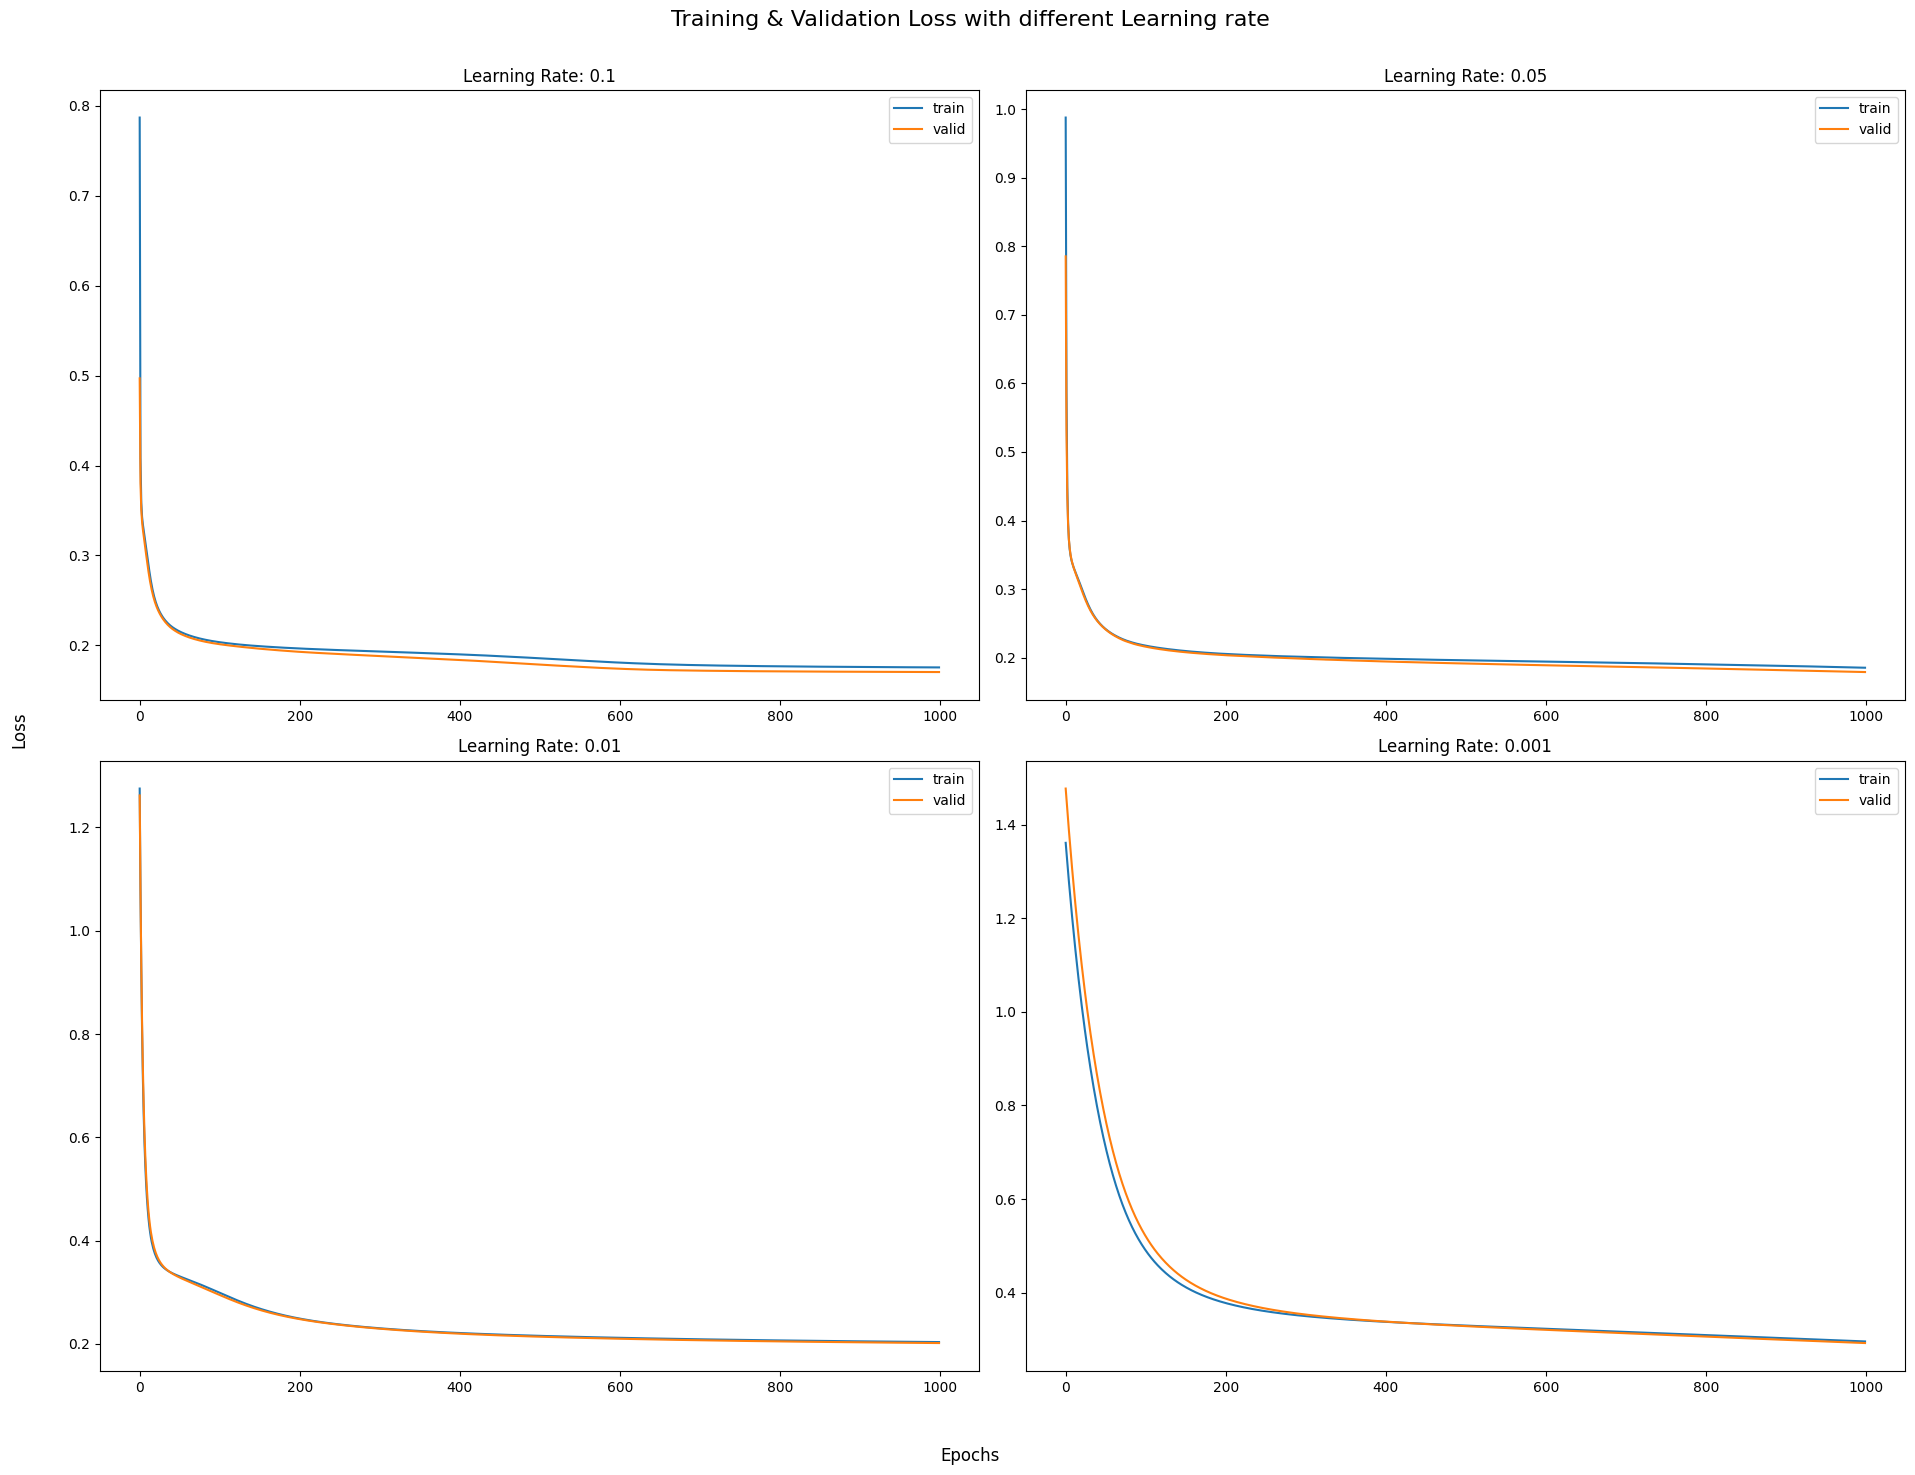

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flat
for i, (lr, train_losses, valid_losses) in enumerate(lr_losses):
    axs[i].plot(train_losses, label="train")
    axs[i].plot(valid_losses, label="valid")
    axs[i].set_title(f"Learning Rate: {lr}")
    axs[i].legend()

fig.suptitle("Training & Validation Loss with different Learning rate", fontsize=16)
fig.supxlabel("Epochs", fontsize=12)
fig.supylabel("Loss", fontsize=12)

plt.tight_layout(rect=[0.025, 0.025, 0.975, 0.975])
plt.show()

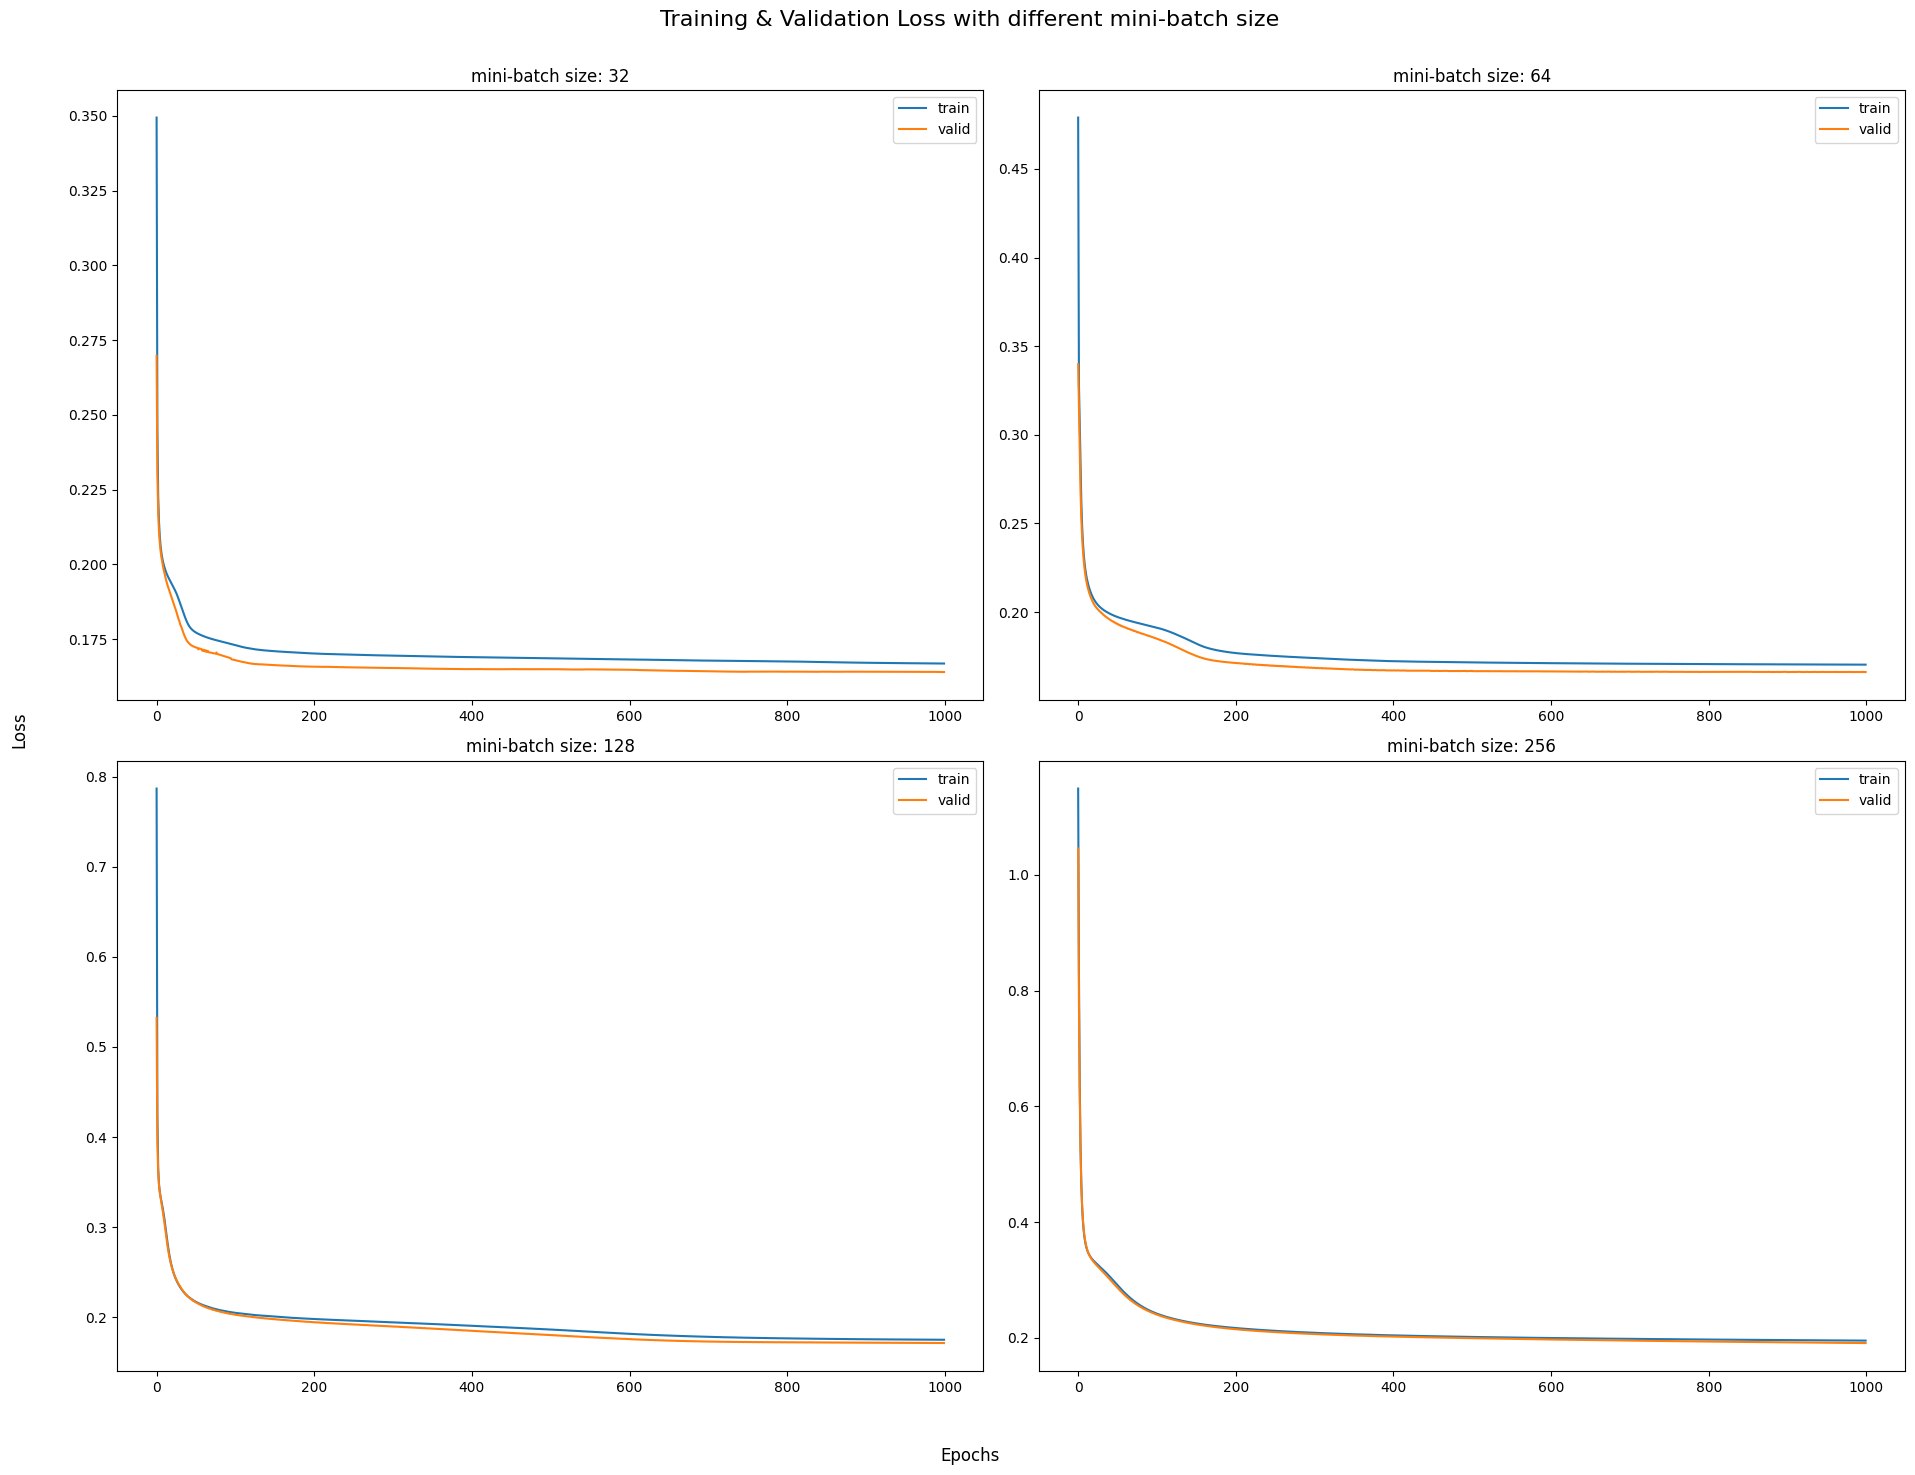

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flat
for i, (mini_batch_size, train_losses, valid_losses) in enumerate(batch_losses):
    axs[i].plot(train_losses, label="train")
    axs[i].plot(valid_losses, label="valid")
    axs[i].set_title(f"mini-batch size: {mini_batch_size}")
    axs[i].legend()

fig.suptitle("Training & Validation Loss with different mini-batch size", fontsize=16)
fig.supxlabel("Epochs", fontsize=12)
fig.supylabel("Loss", fontsize=12)

plt.tight_layout(rect=[0.025, 0.025, 0.975, 0.975])
plt.show()

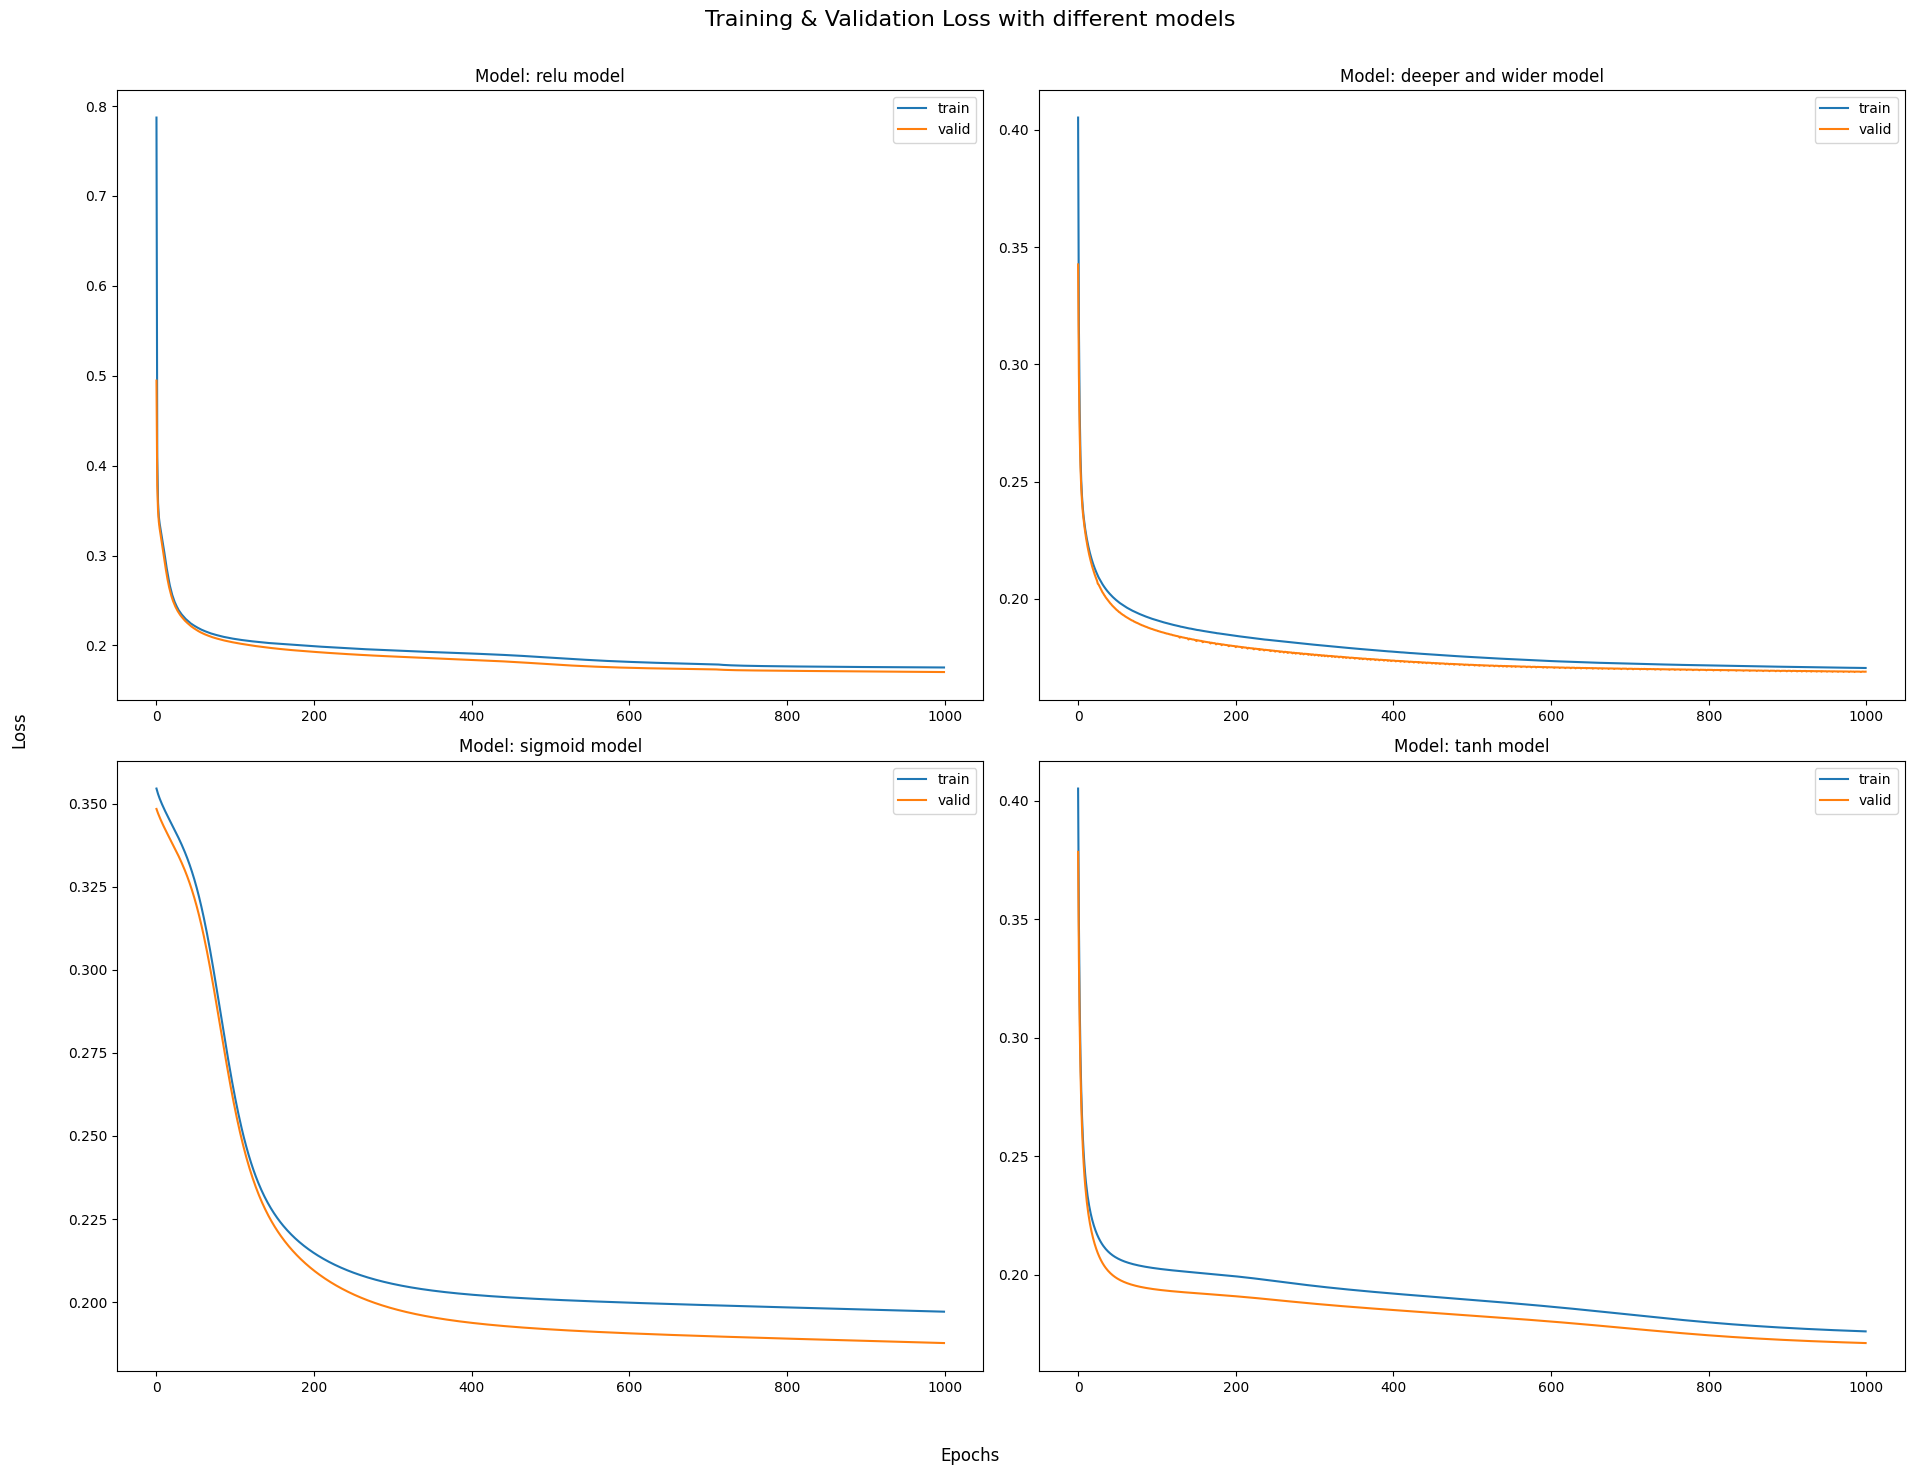

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flat
for i, (model_desc, train_losses, valid_losses) in enumerate(model_losses):
    axs[i].plot(train_losses, label="train")
    axs[i].plot(valid_losses, label="valid")
    axs[i].set_title(f"Model: {model_desc}")
    axs[i].legend()

fig.suptitle("Training & Validation Loss with different models", fontsize=16)
fig.supxlabel("Epochs", fontsize=12)
fig.supylabel("Loss", fontsize=12)

plt.tight_layout(rect=[0.025, 0.025, 0.975, 0.975])
plt.show()